In [1]:
!git clone https://github.com/korfoo12/OptMLProject.git

Cloning into 'OptMLProject'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 142 (delta 76), reused 96 (delta 36), pack-reused 0
Receiving objects: 100% (142/142), 8.42 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [2]:
import sys
sys.path.insert(0, '/kaggle/working/OptMLProject/code/')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

In [4]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
seed_generators()

In [6]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 59130692.50it/s] 


Extracting data/cifar-10-python.tar.gz to data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
num_clients = 8
num_classes = 10

In [9]:
proportions = generate_proportions(num_clients,num_classes,alpha=10e8)

In [10]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [11]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
                
    return torch.tensor(results).mean()

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.5251, Accuracy = 0.4476
client 2 : Loss = 1.5763, Accuracy = 0.4289
client 3 : Loss = 1.5215, Accuracy = 0.4407
client 4 : Loss = 1.6339, Accuracy = 0.4016
client 5 : Loss = 1.6196, Accuracy = 0.4154
client 6 : Loss = 1.4412, Accuracy = 0.4764
client 7 : Loss = 1.6493, Accuracy = 0.3928
client 8 : Loss = 1.5896, Accuracy = 0.4309

Server :
    - training loss = 1.9279
    - training accuracy = 0.3041
    - validation loss = 1.9232
    - validation accuracy = 0.3077
        
>>> Round 2 ...
client 1 : Loss = 1.2349, Accuracy = 0.5711
client 2 : Loss = 1.0994, Accuracy = 0.6111
client 3 : Loss = 1.1299, Accuracy = 0.5869
client 4 : Loss = 1.0679, Accuracy = 0.6244
client 5 : Loss = 1.1191, Accuracy = 0.5982
client 6 : Loss = 1.1925, Accuracy = 0.5851
clie

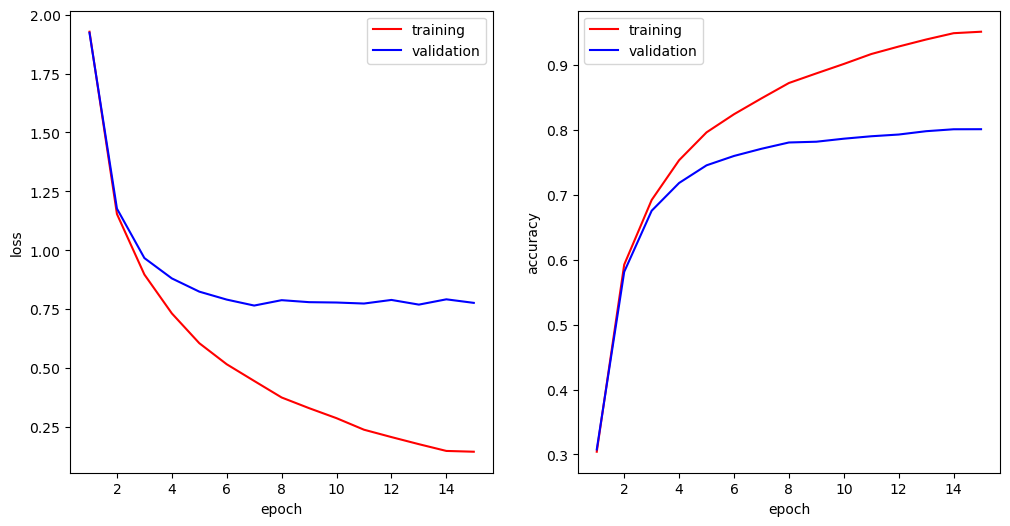

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.5218, Accuracy = 0.4462
client 2 : Loss = 1.7591, Accuracy = 0.3488
client 3 : Loss = 1.5710, Accuracy = 0.4375
client 4 : Loss = 1.5037, Accuracy = 0.4600
client 5 : Loss = 1.4551, Accuracy = 0.4712
client 6 : Loss = 1.4704, Accuracy = 0.4668
client 7 : Loss = 1.8922, Accuracy = 0.3391
client 8 : Loss = 1.5494, Accuracy = 0.4207

Server :
    - training loss = 2.0355
    - training accuracy = 0.2895
    - validation loss = 2.0261
    - validation accuracy = 0.2863
        
>>> Round 2 ...
client 1 : Loss = 1.0820, Accuracy = 0.6204
client 2 : Loss = 1.2257, Accuracy = 0.5615
client 3 : Loss = 1.0738, Accuracy = 0.6193
client 4 : Loss = 1.1335, Accuracy = 0.5830
client 5 : Loss = 1.1076, Accuracy = 0.5988
client 6 : Loss = 1.0992, Accuracy = 0.6115
clie

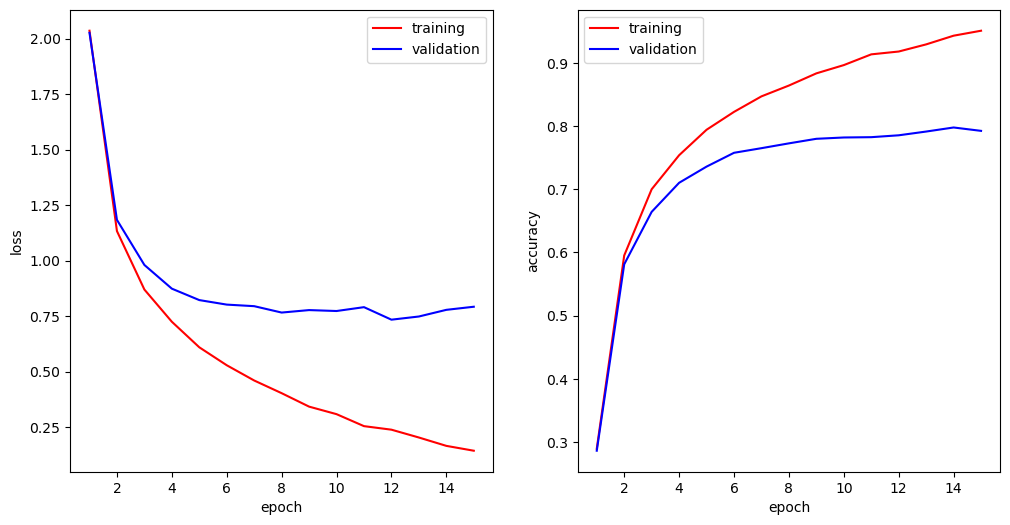

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4925, Accuracy = 0.4557
client 2 : Loss = 1.5741, Accuracy = 0.4282
client 3 : Loss = 1.6288, Accuracy = 0.4141
client 4 : Loss = 1.5912, Accuracy = 0.4265
client 5 : Loss = 1.4384, Accuracy = 0.4760
client 6 : Loss = 1.6675, Accuracy = 0.4020
client 7 : Loss = 1.4137, Accuracy = 0.4807
client 8 : Loss = 1.5859, Accuracy = 0.4230

Server :
    - training loss = 1.9626
    - training accuracy = 0.3027
    - validation loss = 1.9581
    - validation accuracy = 0.3030
        
>>> Round 2 ...
client 1 : Loss = 1.0960, Accuracy = 0.6070
client 2 : Loss = 1.1382, Accuracy = 0.5927
client 3 : Loss = 1.1701, Accuracy = 0.5795
client 4 : Loss = 1.0840, Accuracy = 0.6158
client 5 : Loss = 1.1078, Accuracy = 0.6048
client 6 : Loss = 1.1993, Accuracy = 0.5770
clie

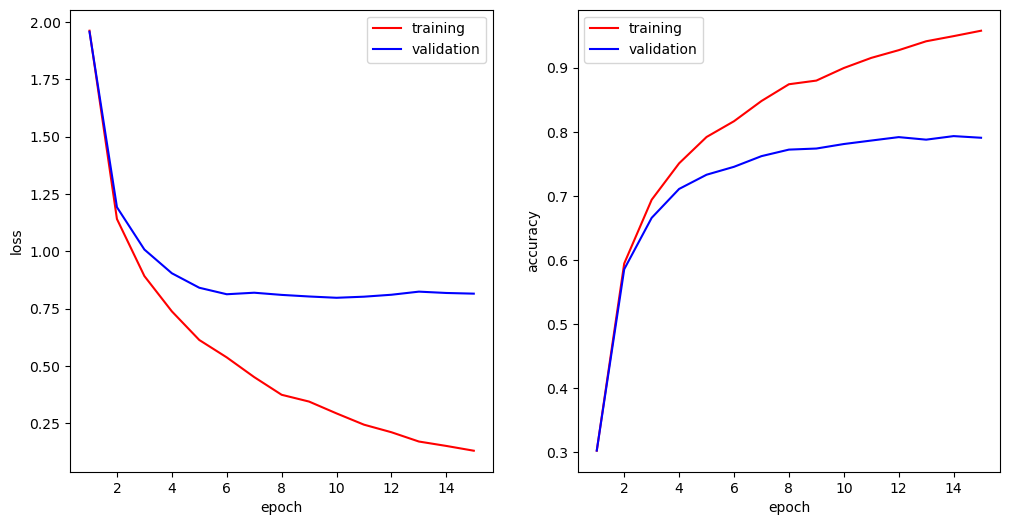

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5049, Accuracy = 0.4589
client 2 : Loss = 1.4336, Accuracy = 0.4855
client 3 : Loss = 1.6797, Accuracy = 0.4072
client 4 : Loss = 1.5894, Accuracy = 0.4225
client 5 : Loss = 1.4543, Accuracy = 0.4704
client 6 : Loss = 1.3994, Accuracy = 0.4854
client 7 : Loss = 1.6351, Accuracy = 0.4113
client 8 : Loss = 1.5798, Accuracy = 0.4203

Server :
    - training loss = 1.8895
    - training accuracy = 0.3022
    - validation loss = 1.8883
    - validation accuracy = 0.3103
        
>>> Round 2 ...
client 1 : Loss = 1.1408, Accuracy = 0.5993
client 2 : Loss = 1.0694, Accuracy = 0.6267
client 3 : Loss = 1.2025, Accuracy = 0.5665
client 4 : Loss = 1.1230, Accuracy = 0.5920
client 5 : Loss = 1.1340, Accuracy = 0.5828
client 6 : Loss = 1.1118, Accuracy = 0.6084
clie

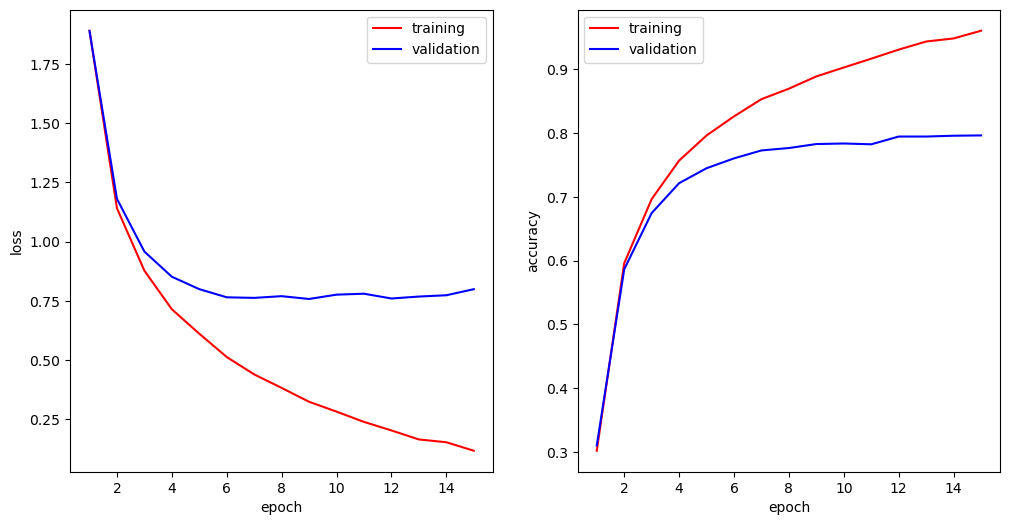

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.6833, Accuracy = 0.3906
client 2 : Loss = 1.5590, Accuracy = 0.4250
client 3 : Loss = 1.6166, Accuracy = 0.4221
client 4 : Loss = 1.7535, Accuracy = 0.3625
client 5 : Loss = 1.5578, Accuracy = 0.4322
client 6 : Loss = 1.6218, Accuracy = 0.4196
client 7 : Loss = 1.4886, Accuracy = 0.4555
client 8 : Loss = 1.5911, Accuracy = 0.4111

Server :
    - training loss = 2.0832
    - training accuracy = 0.2400
    - validation loss = 2.0919
    - validation accuracy = 0.2301
        
>>> Round 2 ...
client 1 : Loss = 1.1923, Accuracy = 0.5717
client 2 : Loss = 1.1432, Accuracy = 0.5840
client 3 : Loss = 1.1754, Accuracy = 0.5787
client 4 : Loss = 1.1583, Accuracy = 0.5843
client 5 : Loss = 1.0658, Accuracy = 0.6087
client 6 : Loss = 1.2307, Accuracy = 0.5585
clie

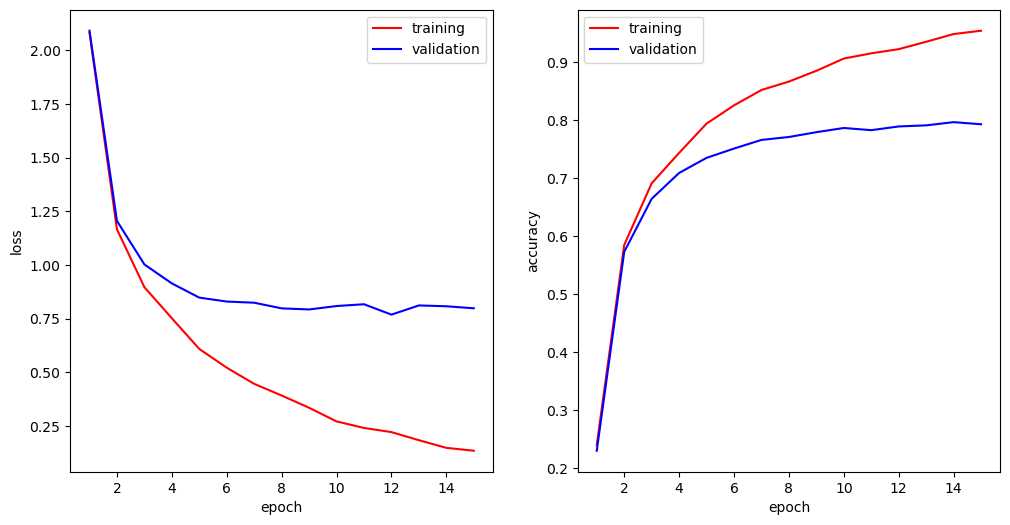

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.1346, Accuracy = 0.5987
client 2 : Loss = 1.1970, Accuracy = 0.5789
client 3 : Loss = 1.1907, Accuracy = 0.5846
client 4 : Loss = 1.1504, Accuracy = 0.5891
client 5 : Loss = 1.1215, Accuracy = 0.6091
client 6 : Loss = 1.3015, Accuracy = 0.5409
client 7 : Loss = 1.0601, Accuracy = 0.6171
client 8 : Loss = 1.1558, Accuracy = 0.5902

Server :
    - training loss = 1.3819
    - training accuracy = 0.5124
    - validation loss = 1.4069
    - validation accuracy = 0.5050
        
>>> Round 2 ...
client 1 : Loss = 0.9100, Accuracy = 0.6733
client 2 : Loss = 0.8400, Accuracy = 0.6973
client 3 : Loss = 0.9101, Accuracy = 0.6760
client 4 : Loss = 0.8736, Accuracy = 0.6879
client 5 : Loss = 0.7986, Accuracy = 0.7156
client 6 : Loss = 0.9217, Accuracy = 0.6723
clie

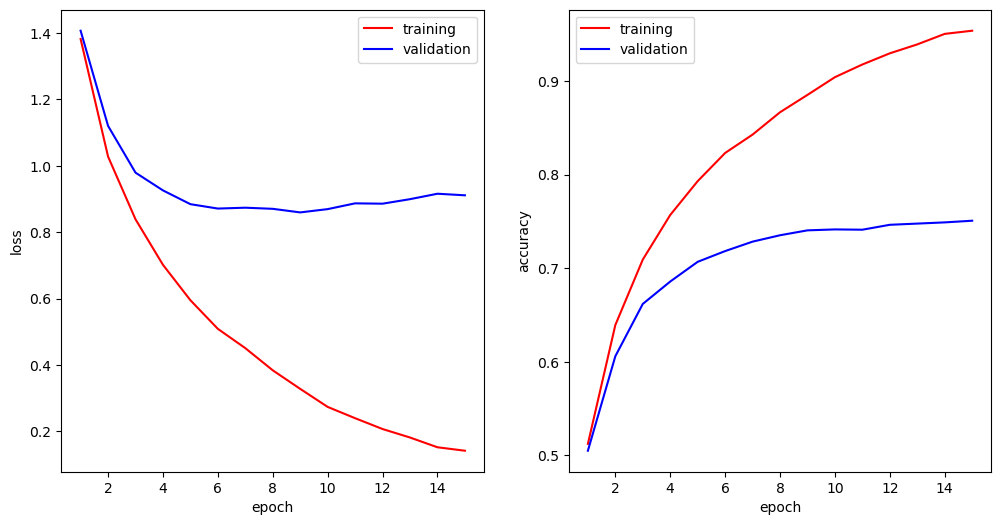

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.0662, Accuracy = 0.6163
client 2 : Loss = 1.3203, Accuracy = 0.5365
client 3 : Loss = 1.0511, Accuracy = 0.6210
client 4 : Loss = 1.1128, Accuracy = 0.6068
client 5 : Loss = 1.1153, Accuracy = 0.6035
client 6 : Loss = 1.1292, Accuracy = 0.5997
client 7 : Loss = 1.4071, Accuracy = 0.5037
client 8 : Loss = 1.1210, Accuracy = 0.6017

Server :
    - training loss = 1.3792
    - training accuracy = 0.5187
    - validation loss = 1.4383
    - validation accuracy = 0.4968
        
>>> Round 2 ...
client 1 : Loss = 0.8557, Accuracy = 0.6983
client 2 : Loss = 0.8542, Accuracy = 0.6990
client 3 : Loss = 0.8024, Accuracy = 0.7186
client 4 : Loss = 0.8493, Accuracy = 0.6922
client 5 : Loss = 0.7728, Accuracy = 0.7194
client 6 : Loss = 0.8105, Accuracy = 0.7079
clie

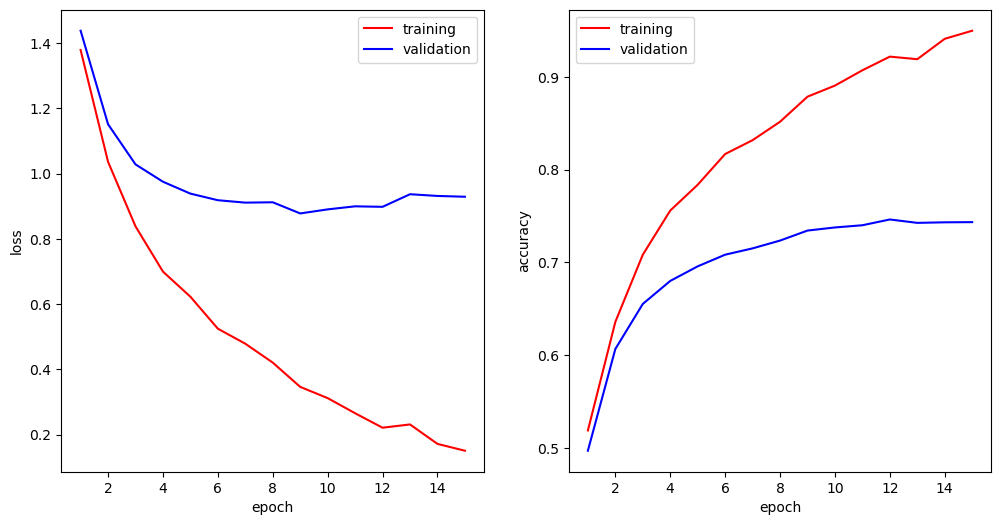

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.2264, Accuracy = 0.5650
client 2 : Loss = 1.2624, Accuracy = 0.5504
client 3 : Loss = 1.2225, Accuracy = 0.5826
client 4 : Loss = 1.1664, Accuracy = 0.5878
client 5 : Loss = 1.1526, Accuracy = 0.5873
client 6 : Loss = 1.1978, Accuracy = 0.5748
client 7 : Loss = 1.2977, Accuracy = 0.5426
client 8 : Loss = 1.1953, Accuracy = 0.5713

Server :
    - training loss = 1.3959
    - training accuracy = 0.5079
    - validation loss = 1.4362
    - validation accuracy = 0.4962
        
>>> Round 2 ...
client 1 : Loss = 0.8384, Accuracy = 0.6920
client 2 : Loss = 0.8943, Accuracy = 0.6809
client 3 : Loss = 0.9019, Accuracy = 0.6752
client 4 : Loss = 0.8522, Accuracy = 0.6894
client 5 : Loss = 0.9194, Accuracy = 0.6749
client 6 : Loss = 0.8311, Accuracy = 0.7078
clie

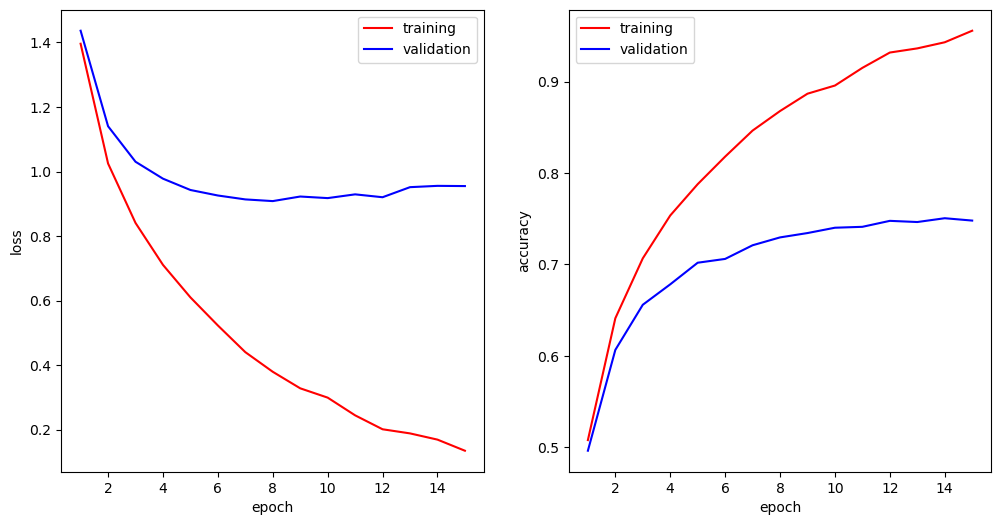

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.2963, Accuracy = 0.5493
client 2 : Loss = 1.1623, Accuracy = 0.5851
client 3 : Loss = 1.1783, Accuracy = 0.5779
client 4 : Loss = 1.2361, Accuracy = 0.5732
client 5 : Loss = 1.2607, Accuracy = 0.5488
client 6 : Loss = 1.1906, Accuracy = 0.5717
client 7 : Loss = 1.2149, Accuracy = 0.5594
client 8 : Loss = 1.2461, Accuracy = 0.5533

Server :
    - training loss = 1.3749
    - training accuracy = 0.5097
    - validation loss = 1.4126
    - validation accuracy = 0.4986
        
>>> Round 2 ...
client 1 : Loss = 0.8616, Accuracy = 0.7011
client 2 : Loss = 0.7918, Accuracy = 0.7192
client 3 : Loss = 0.9394, Accuracy = 0.6642
client 4 : Loss = 0.9721, Accuracy = 0.6578
client 5 : Loss = 0.9390, Accuracy = 0.6694
client 6 : Loss = 0.8292, Accuracy = 0.7012
clie

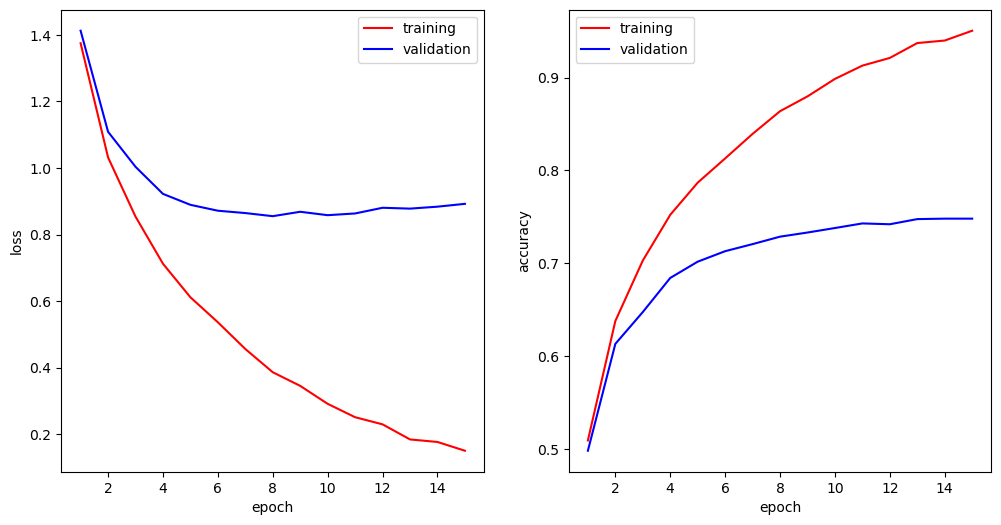

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.2178, Accuracy = 0.5766
client 2 : Loss = 1.0887, Accuracy = 0.6000
client 3 : Loss = 1.1889, Accuracy = 0.5844
client 4 : Loss = 1.1030, Accuracy = 0.6015
client 5 : Loss = 1.2279, Accuracy = 0.5724
client 6 : Loss = 1.1655, Accuracy = 0.5943
client 7 : Loss = 1.1681, Accuracy = 0.5859
client 8 : Loss = 1.1234, Accuracy = 0.6076

Server :
    - training loss = 1.3695
    - training accuracy = 0.5197
    - validation loss = 1.4119
    - validation accuracy = 0.5051
        
>>> Round 2 ...
client 1 : Loss = 0.8942, Accuracy = 0.6861
client 2 : Loss = 0.8431, Accuracy = 0.6973
client 3 : Loss = 0.8160, Accuracy = 0.7074
client 4 : Loss = 1.0069, Accuracy = 0.6440
client 5 : Loss = 0.8056, Accuracy = 0.7118
client 6 : Loss = 0.8570, Accuracy = 0.6941
clie

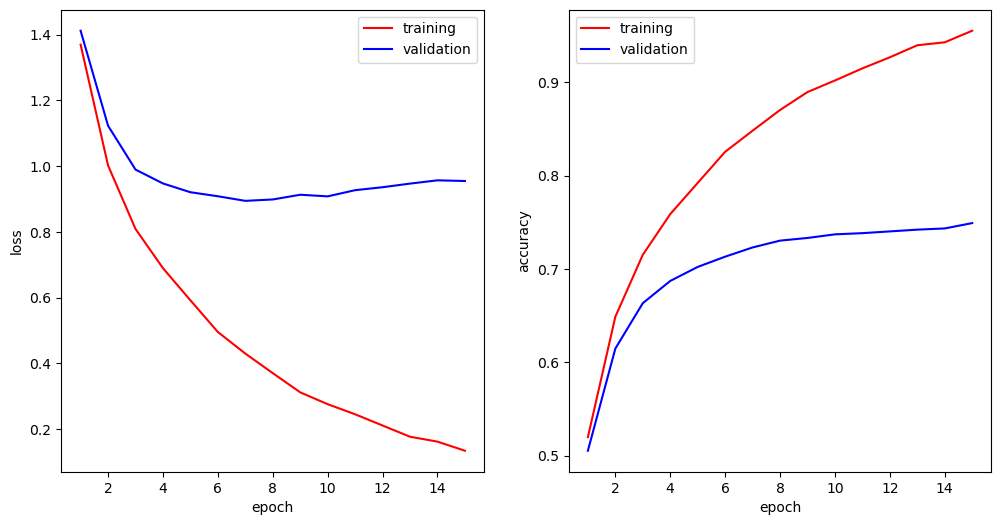

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4992, Accuracy = 0.4648
client 2 : Loss = 1.4602, Accuracy = 0.4740
client 3 : Loss = 1.4897, Accuracy = 0.4633
client 4 : Loss = 1.4911, Accuracy = 0.4725
client 5 : Loss = 1.5041, Accuracy = 0.4656
client 6 : Loss = 1.4965, Accuracy = 0.4674
client 7 : Loss = 1.4937, Accuracy = 0.4612
client 8 : Loss = 1.5216, Accuracy = 0.4586

Server :
    - training loss = 1.5146
    - training accuracy = 0.4541
    - validation loss = 1.5593
    - validation accuracy = 0.4347
        
>>> Round 2 ...
client 1 : Loss = 1.3223, Accuracy = 0.5374
client 2 : Loss = 1.2837, Accuracy = 0.5371
client 3 : Loss = 1.2821, Accuracy = 0.5433
client 4 : Loss = 1.2649, Accuracy = 0.5496
client 5 : Loss = 1.2725, Accuracy = 0.5515
client 6 : Loss = 1.2983, Accuracy = 0.5433
clie

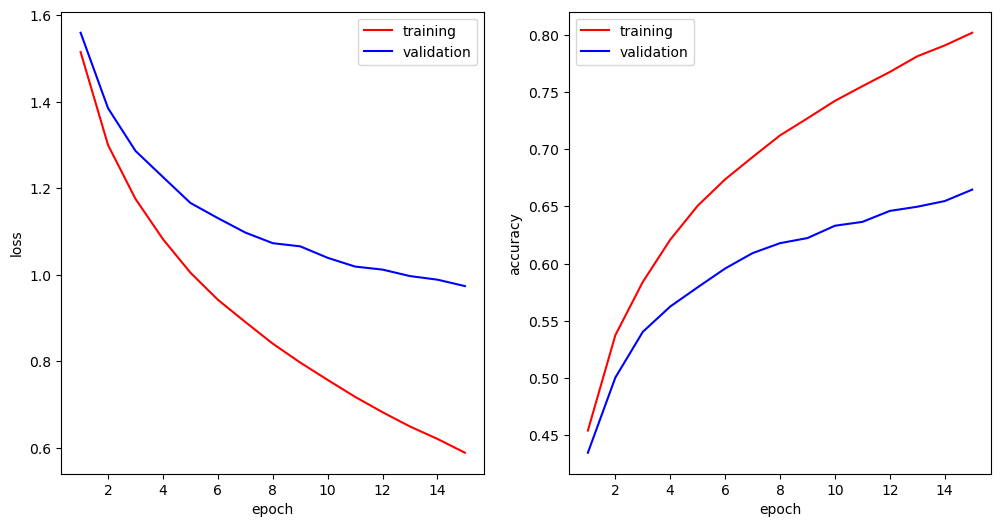

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.5255, Accuracy = 0.4698
client 2 : Loss = 1.5479, Accuracy = 0.4430
client 3 : Loss = 1.4939, Accuracy = 0.4728
client 4 : Loss = 1.5315, Accuracy = 0.4629
client 5 : Loss = 1.5564, Accuracy = 0.4366
client 6 : Loss = 1.5168, Accuracy = 0.4574
client 7 : Loss = 1.5755, Accuracy = 0.4447
client 8 : Loss = 1.5163, Accuracy = 0.4563

Server :
    - training loss = 1.5337
    - training accuracy = 0.4491
    - validation loss = 1.5943
    - validation accuracy = 0.4267
        
>>> Round 2 ...
client 1 : Loss = 1.3306, Accuracy = 0.5345
client 2 : Loss = 1.3435, Accuracy = 0.5164
client 3 : Loss = 1.2884, Accuracy = 0.5414
client 4 : Loss = 1.3235, Accuracy = 0.5273
client 5 : Loss = 1.3183, Accuracy = 0.5263
client 6 : Loss = 1.2868, Accuracy = 0.5383
clie

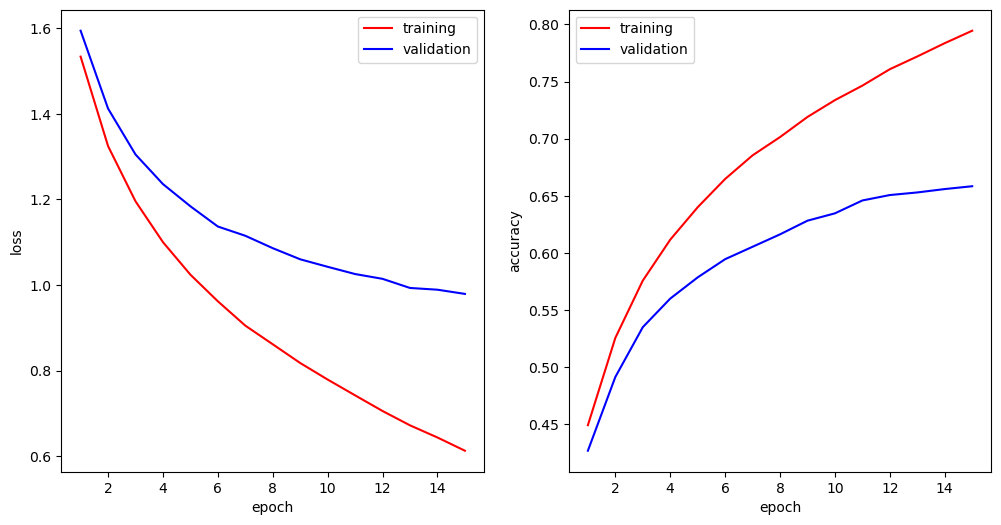

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4731, Accuracy = 0.4750
client 2 : Loss = 1.5158, Accuracy = 0.4495
client 3 : Loss = 1.5053, Accuracy = 0.4631
client 4 : Loss = 1.4949, Accuracy = 0.4604
client 5 : Loss = 1.4771, Accuracy = 0.4719
client 6 : Loss = 1.4919, Accuracy = 0.4604
client 7 : Loss = 1.5060, Accuracy = 0.4720
client 8 : Loss = 1.5209, Accuracy = 0.4521

Server :
    - training loss = 1.5029
    - training accuracy = 0.4573
    - validation loss = 1.5564
    - validation accuracy = 0.4400
        
>>> Round 2 ...
client 1 : Loss = 1.2456, Accuracy = 0.5588
client 2 : Loss = 1.2997, Accuracy = 0.5340
client 3 : Loss = 1.3060, Accuracy = 0.5369
client 4 : Loss = 1.3080, Accuracy = 0.5300
client 5 : Loss = 1.2894, Accuracy = 0.5375
client 6 : Loss = 1.2583, Accuracy = 0.5561
clie

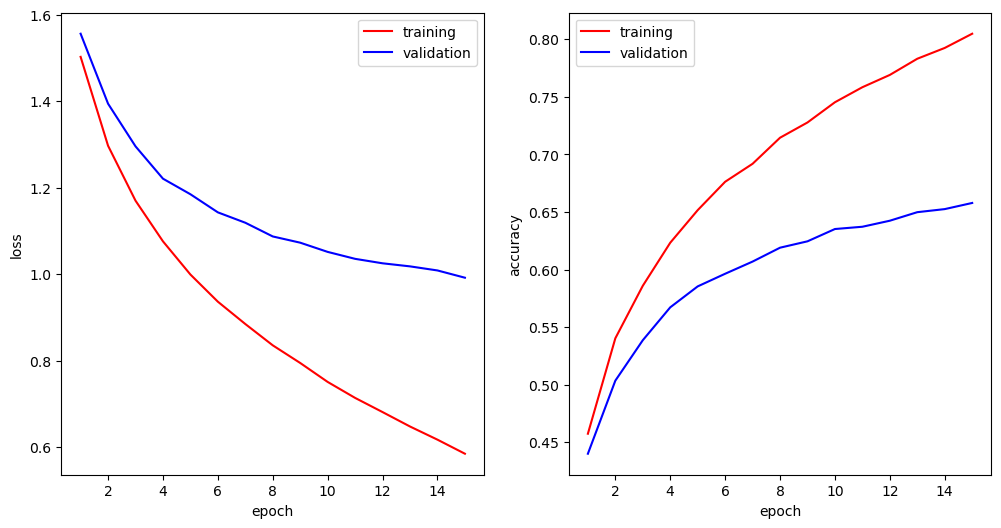

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5378, Accuracy = 0.4567
client 2 : Loss = 1.5135, Accuracy = 0.4640
client 3 : Loss = 1.5873, Accuracy = 0.4435
client 4 : Loss = 1.5513, Accuracy = 0.4564
client 5 : Loss = 1.5355, Accuracy = 0.4554
client 6 : Loss = 1.5107, Accuracy = 0.4652
client 7 : Loss = 1.5307, Accuracy = 0.4548
client 8 : Loss = 1.5638, Accuracy = 0.4378

Server :
    - training loss = 1.5261
    - training accuracy = 0.4506
    - validation loss = 1.5838
    - validation accuracy = 0.4343
        
>>> Round 2 ...
client 1 : Loss = 1.3183, Accuracy = 0.5278
client 2 : Loss = 1.3138, Accuracy = 0.5422
client 3 : Loss = 1.3191, Accuracy = 0.5297
client 4 : Loss = 1.3508, Accuracy = 0.5178
client 5 : Loss = 1.3018, Accuracy = 0.5377
client 6 : Loss = 1.2982, Accuracy = 0.5312
clie

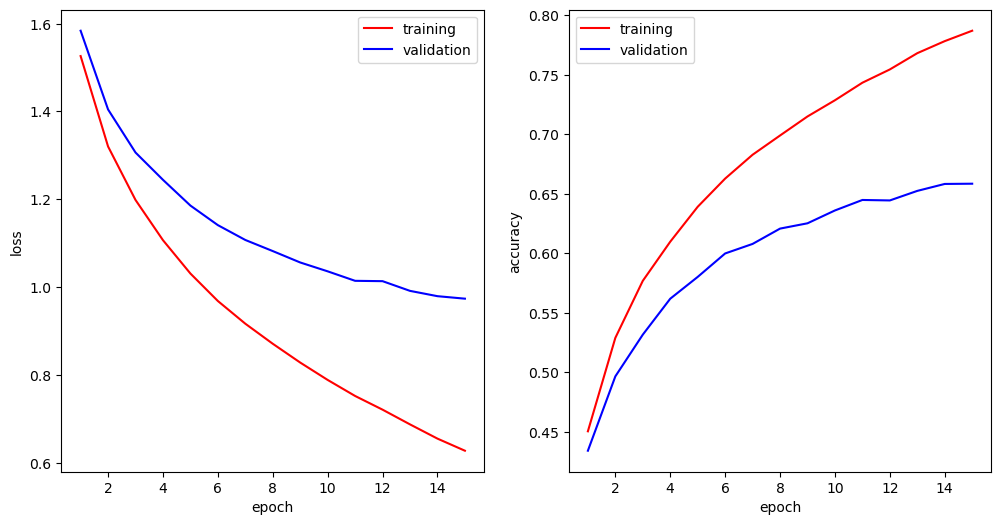

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.4996, Accuracy = 0.4666
client 2 : Loss = 1.5052, Accuracy = 0.4623
client 3 : Loss = 1.4947, Accuracy = 0.4680
client 4 : Loss = 1.5019, Accuracy = 0.4672
client 5 : Loss = 1.5203, Accuracy = 0.4682
client 6 : Loss = 1.4969, Accuracy = 0.4695
client 7 : Loss = 1.5409, Accuracy = 0.4586
client 8 : Loss = 1.4970, Accuracy = 0.4683

Server :
    - training loss = 1.5212
    - training accuracy = 0.4558
    - validation loss = 1.5873
    - validation accuracy = 0.4293
        
>>> Round 2 ...
client 1 : Loss = 1.2715, Accuracy = 0.5436
client 2 : Loss = 1.2889, Accuracy = 0.5344
client 3 : Loss = 1.2761, Accuracy = 0.5502
client 4 : Loss = 1.2852, Accuracy = 0.5520
client 5 : Loss = 1.2831, Accuracy = 0.5474
client 6 : Loss = 1.3040, Accuracy = 0.5311
clie

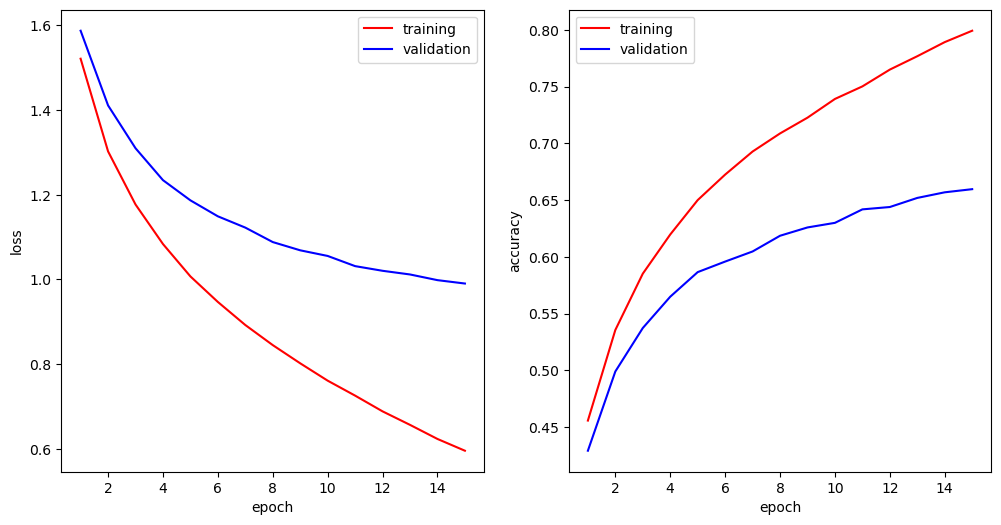

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.3514, Accuracy = 0.2085
client 2 : Loss = 2.3656, Accuracy = 0.2118
client 3 : Loss = 2.3264, Accuracy = 0.2264
client 4 : Loss = 2.3641, Accuracy = 0.2125
client 5 : Loss = 2.3675, Accuracy = 0.2097
client 6 : Loss = 2.3945, Accuracy = 0.2100
client 7 : Loss = 2.3412, Accuracy = 0.2218
client 8 : Loss = 2.3692, Accuracy = 0.2072

Server :
    - training loss = 2.0509
    - training accuracy = 0.2568
    - validation loss = 2.0759
    - validation accuracy = 0.2448
        
>>> Round 2 ...
client 1 : Loss = 2.1797, Accuracy = 0.2698
client 2 : Loss = 2.1358, Accuracy = 0.2739
client 3 : Loss = 2.1602, Accuracy = 0.2745
client 4 : Loss = 2.1402, Accuracy = 0.2734
client 5 : Loss = 2.1523, Accuracy = 0.2631
client 6 : Loss = 2.1306, Accuracy = 0.2745
clie

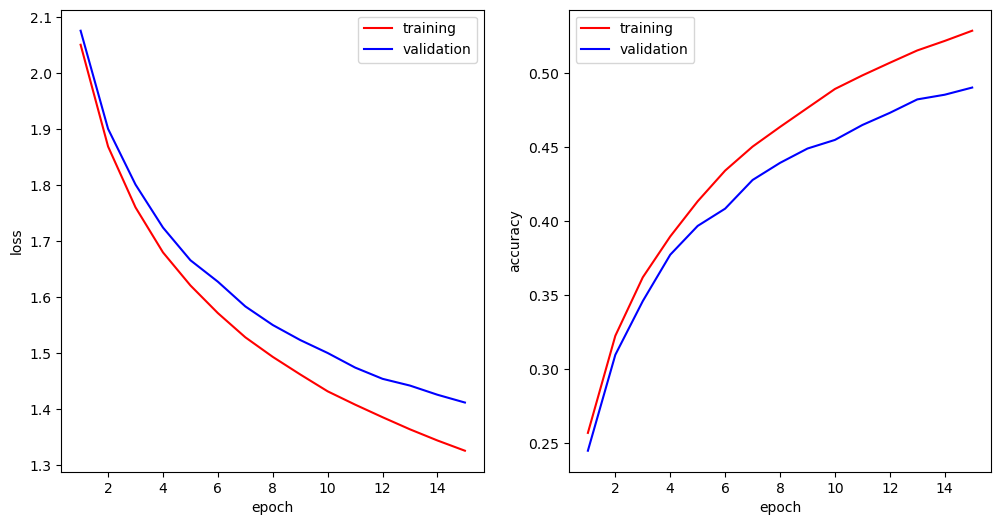

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 2.3762, Accuracy = 0.2041
client 2 : Loss = 2.3325, Accuracy = 0.2270
client 3 : Loss = 2.3489, Accuracy = 0.2286
client 4 : Loss = 2.3379, Accuracy = 0.2160
client 5 : Loss = 2.3748, Accuracy = 0.2090
client 6 : Loss = 2.3955, Accuracy = 0.2062
client 7 : Loss = 2.3208, Accuracy = 0.2260
client 8 : Loss = 2.3202, Accuracy = 0.2186

Server :
    - training loss = 2.0539
    - training accuracy = 0.2659
    - validation loss = 2.0701
    - validation accuracy = 0.2553
        
>>> Round 2 ...
client 1 : Loss = 2.1549, Accuracy = 0.2680
client 2 : Loss = 2.1150, Accuracy = 0.2832
client 3 : Loss = 2.1160, Accuracy = 0.2765
client 4 : Loss = 2.1367, Accuracy = 0.2748
client 5 : Loss = 2.1669, Accuracy = 0.2722
client 6 : Loss = 2.1602, Accuracy = 0.2700
clie

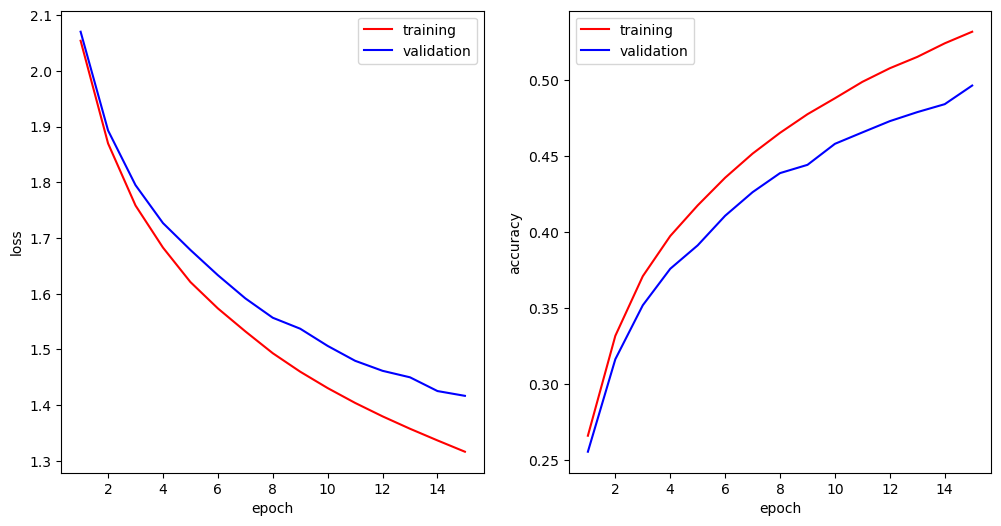

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.3530, Accuracy = 0.2094
client 2 : Loss = 2.3364, Accuracy = 0.2151
client 3 : Loss = 2.3676, Accuracy = 0.2143
client 4 : Loss = 2.3410, Accuracy = 0.2157
client 5 : Loss = 2.3363, Accuracy = 0.2238
client 6 : Loss = 2.3579, Accuracy = 0.2217
client 7 : Loss = 2.3877, Accuracy = 0.2169
client 8 : Loss = 2.3555, Accuracy = 0.2078

Server :
    - training loss = 2.0469
    - training accuracy = 0.2580
    - validation loss = 2.0518
    - validation accuracy = 0.2560
        
>>> Round 2 ...
client 1 : Loss = 2.1115, Accuracy = 0.2814
client 2 : Loss = 2.1506, Accuracy = 0.2659
client 3 : Loss = 2.1740, Accuracy = 0.2613
client 4 : Loss = 2.1547, Accuracy = 0.2784
client 5 : Loss = 2.1702, Accuracy = 0.2663
client 6 : Loss = 2.1409, Accuracy = 0.2781
clie

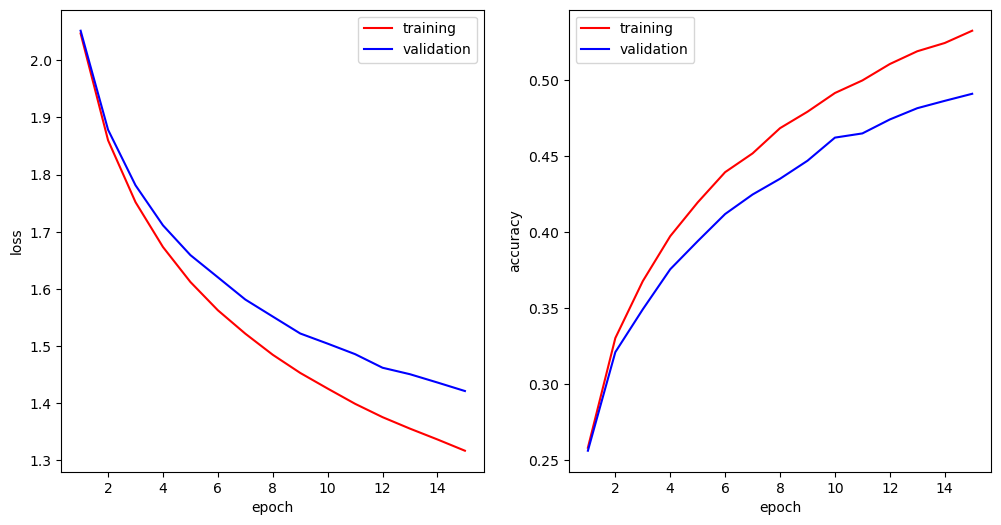

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.3541, Accuracy = 0.2155
client 2 : Loss = 2.3578, Accuracy = 0.2185
client 3 : Loss = 2.3980, Accuracy = 0.2071
client 4 : Loss = 2.3521, Accuracy = 0.2199
client 5 : Loss = 2.3454, Accuracy = 0.2125
client 6 : Loss = 2.3755, Accuracy = 0.2150
client 7 : Loss = 2.3771, Accuracy = 0.2160
client 8 : Loss = 2.3867, Accuracy = 0.2035

Server :
    - training loss = 2.0695
    - training accuracy = 0.2602
    - validation loss = 2.0957
    - validation accuracy = 0.2527
        
>>> Round 2 ...
client 1 : Loss = 2.1325, Accuracy = 0.2758
client 2 : Loss = 2.1765, Accuracy = 0.2681
client 3 : Loss = 2.1986, Accuracy = 0.2552
client 4 : Loss = 2.1216, Accuracy = 0.2799
client 5 : Loss = 2.1295, Accuracy = 0.2819
client 6 : Loss = 2.1526, Accuracy = 0.2686
clie

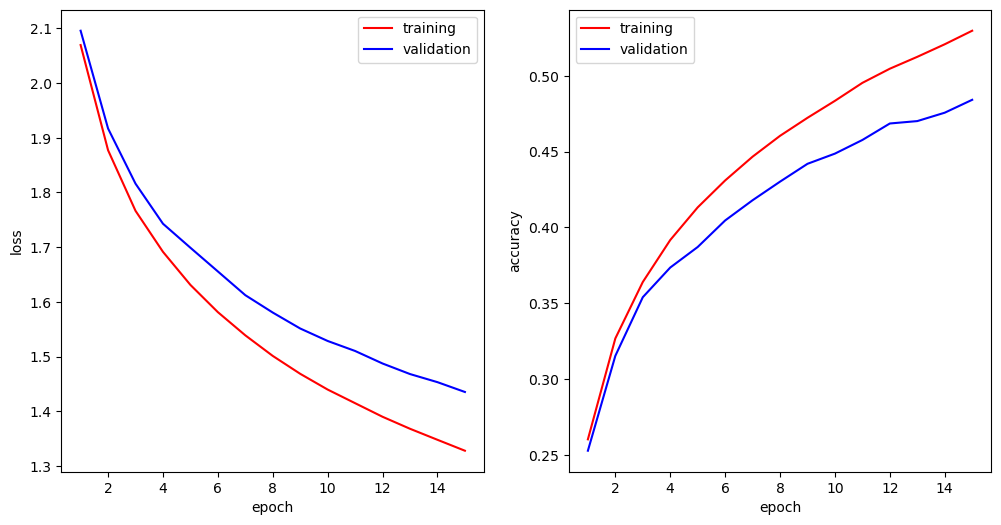

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2.3168, Accuracy = 0.2248
client 2 : Loss = 2.3140, Accuracy = 0.2316
client 3 : Loss = 2.3011, Accuracy = 0.2367
client 4 : Loss = 2.3065, Accuracy = 0.2288
client 5 : Loss = 2.3140, Accuracy = 0.2245
client 6 : Loss = 2.3391, Accuracy = 0.2243
client 7 : Loss = 2.2685, Accuracy = 0.2328
client 8 : Loss = 2.3468, Accuracy = 0.2340

Server :
    - training loss = 2.0164
    - training accuracy = 0.2717
    - validation loss = 2.0452
    - validation accuracy = 0.2641
        
>>> Round 2 ...
client 1 : Loss = 2.1129, Accuracy = 0.2699
client 2 : Loss = 2.1081, Accuracy = 0.2791
client 3 : Loss = 2.1440, Accuracy = 0.2678
client 4 : Loss = 2.1264, Accuracy = 0.2707
client 5 : Loss = 2.1337, Accuracy = 0.2654
client 6 : Loss = 2.1508, Accuracy = 0.2771
clie

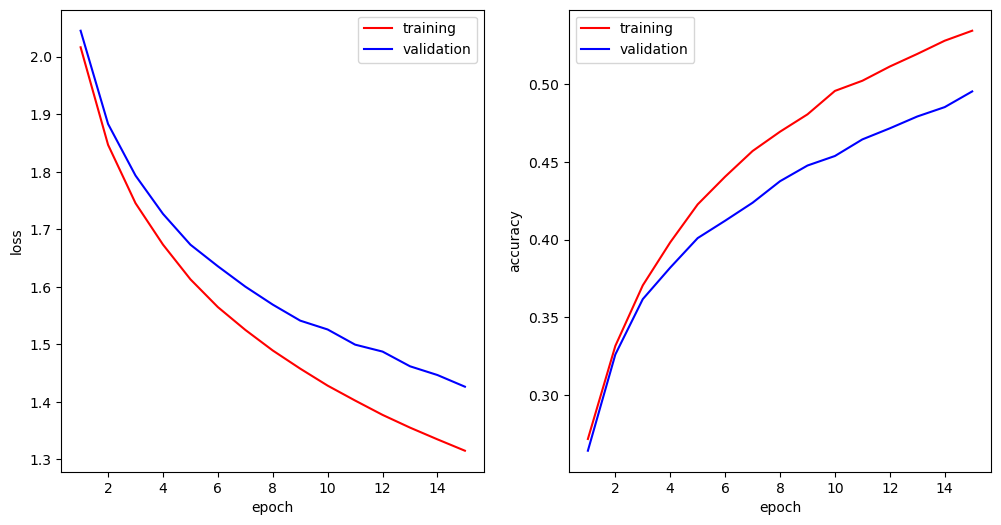

RESULTS
lr = 0.1000 : Accuracy = 0.7947982549667358
lr = 0.0100 : Accuracy = 0.7478639483451843
lr = 0.0010 : Accuracy = 0.6597903370857239
lr = 0.0001 : Accuracy = 0.4914754331111908

CPU times: user 5h 1min 52s, sys: 44.1 s, total: 5h 2min 36s
Wall time: 5h 4min 2s


In [12]:
%%time
n_splits = 5
rounds = 15
batch_size = 128
epochs = 5
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
optimizer = optim.SGD

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,momentum=0.9)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()

# IID Dataset

In [13]:
# split data with alpha=10e8 for iid
proportions = generate_proportions(num_clients,num_classes)
proportions

[tensor([1.9233e-11, 3.9803e-07, 2.7796e-03, 3.1345e-06, 7.6924e-01, 9.9539e-03,
         2.0502e-01, 1.3005e-02]),
 tensor([5.2924e-02, 1.4922e-04, 1.5788e-07, 5.6528e-03, 4.3137e-01, 5.0990e-01,
         1.0921e-10, 5.9307e-16]),
 tensor([4.2513e-03, 9.2485e-02, 5.4931e-08, 9.9675e-05, 3.7612e-08, 2.9738e-02,
         5.6423e-01, 3.0920e-01]),
 tensor([5.5930e-02, 5.9044e-03, 3.1633e-01, 9.7237e-05, 4.2666e-05, 4.0609e-07,
         2.6871e-06, 6.2169e-01]),
 tensor([1.3940e-02, 6.9778e-03, 1.4813e-02, 6.8699e-06, 3.6841e-06, 7.7270e-01,
         6.2169e-11, 1.9156e-01]),
 tensor([1.5621e-06, 3.8984e-02, 2.3320e-04, 9.6024e-01, 5.0738e-04, 3.2799e-18,
         3.1969e-10, 3.4284e-05]),
 tensor([1.6298e-01, 2.9460e-01, 5.3644e-01, 1.1773e-07, 1.2973e-03, 4.6607e-03,
         1.3318e-08, 2.4805e-05]),
 tensor([1.5778e-02, 6.0932e-01, 4.7614e-07, 2.6580e-04, 2.9133e-02, 1.5828e-05,
         3.4548e-01, 8.6781e-19]),
 tensor([7.9297e-01, 5.5573e-09, 3.0565e-05, 1.0624e-01, 2.2657e-06, 9.1

In [14]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr, momentum=0.9)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()

Fold #0
client 1 : 4383 samples
client 2 : 6930 samples
client 3 : 3479 samples
client 4 : 4276 samples
client 5 : 4958 samples
client 6 : 5736 samples
client 7 : 4450 samples
client 8 : 5788 samples

>>> Round 1 ...


TypeError: Adam.__init__() got an unexpected keyword argument 'momentum'